## Initialization and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

# Start to parse loan eligibility data
loan_data = pd.read_csv('../project_1/data/loan_eligibility.csv')

loan_attr_data = loan_data.loc[:, loan_data.columns != 'Loan_Status']
loan_status_data = loan_data['Loan_Status']
loan_x_train, loan_x_test, loan_y_train, loan_y_test = train_test_split(loan_attr_data, loan_status_data, random_state=0)
numeric_feats = loan_x_train.select_dtypes(include=np.number).columns.tolist()  # apply scaling

loan_ct = make_column_transformer(    
    (StandardScaler(), numeric_feats)
)
loan_x_train_transformed = loan_ct.fit_transform(loan_x_train)
loan_x_test_transformed = loan_ct.transform(loan_x_test)

# Start to parse Math performance data
math_data = pd.read_csv('../project_1/data/Maths.csv')
math_attr_data = math_data.loc[:, math_data.columns != 'G3']
math_status_data = math_data['G3']

math_x_train, math_x_test, math_y_train, math_y_test = train_test_split(math_attr_data, math_status_data, random_state=0)

numeric_feats = math_x_train.select_dtypes(include=np.number).columns.tolist()  # apply scaling
categorical_feats = ["school", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian"]  # apply one-hot encoding
binary_feats = ["sex", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", 'internet', 'romantic']

math_ct = make_column_transformer(    
    (StandardScaler(), numeric_feats),  # scaling on numeric features
    (OneHotEncoder(), categorical_feats),  # OHE on categorical features
    (OneHotEncoder(drop="if_binary"), binary_feats),
)
math_x_train_transformed = math_ct.fit_transform(math_x_train)
math_x_test_transformed = math_ct.transform(math_x_test)

## k Means

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score

k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]
def compare_k_values(train_X, y):
    loan_fit_time = []
    loan_pred_time = []
    loan_sil_scores = []
    loan_rand_scores = []
    loan_mi_scores = []
    loan_inertias = []
    for k in k_values:
        kmeans_model = KMeans(n_clusters=k, random_state=123, max_iter=100, init='random')

        loan_fit_t0 = time()
        kmeans_loan = kmeans_model.fit(train_X)
        loan_fit_t1 = time()
        loan_fit_time.append(loan_fit_t1 - loan_fit_t0)
        loan_pred = kmeans_loan.predict(train_X)
        loan_pred_t1 = time()
        loan_pred_time.append(loan_pred_t1 - loan_fit_t1)
        loan_sil_scores.append(silhouette_score(train_X, loan_pred, random_state=123))
        loan_rand_scores.append(adjusted_rand_score(y, loan_pred))
        loan_mi_scores.append(adjusted_mutual_info_score(y, loan_pred))
        loan_inertias.append(kmeans_loan.inertia_)

    loan_metric_df = pd.DataFrame(
        {
            'k': k_values,
            'fit_time': loan_fit_time,
            'pred_time': loan_pred_time,
            'silhouette_score': loan_sil_scores,
            'adjusted_rand_score': loan_rand_scores, 
            'adjusted_mutual_info_score': loan_mi_scores,
            'inertias': loan_inertias
        }
    )
    return loan_metric_df

In [3]:
import altair as alt

def plot_kmeans(kmeans_df, simple=False):
    if simple:
        repeated_columns = ['silhouette_score', 'adjusted_rand_score',
           'adjusted_mutual_info_score']
    else:
        repeated_columns = ['fit_time', 'pred_time', 'inertias', 'silhouette_score', 'adjusted_rand_score',
           'adjusted_mutual_info_score']
    
    k_means_chart = alt.Chart(kmeans_df).mark_line(opacity=0.8, point=True).encode(
         alt.X('k'),
         alt.Y(alt.repeat(), type='quantitative', scale=alt.Scale(zero=False))
    ).properties(
        width=200,
        height=200
    ).repeat(
        repeated_columns,
        columns=3
    )
    return k_means_chart

In [4]:
loan_metric_df = compare_k_values(loan_x_train_transformed, loan_y_train)
plot_kmeans(loan_metric_df)

alt.RepeatChart(...)

In [5]:
math_metric_df = compare_k_values(math_x_train_transformed, math_y_train)
plot_kmeans(math_metric_df)

alt.RepeatChart(...)

## Expectation Maximization

In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score

n_components_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80]

def compare_n_values(train_X, y):
    loan_fit_time = []
    loan_pred_time = []
    loan_sil_scores = []
    loan_rand_scores = []
    loan_mi_scores = []
    loan_lower_bounds = []
    for n_components in n_components_values:
        gm_model = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=100, init_params='kmeans', random_state=123)

        loan_fit_t0 = time()
        gm_loan = gm_model.fit(train_X)
        loan_fit_t1 = time()
        loan_fit_time.append(loan_fit_t1 - loan_fit_t0)
        loan_pred = gm_loan.predict(train_X)
        loan_pred_t1 = time()
        loan_pred_time.append(loan_pred_t1 - loan_fit_t1)
        loan_sil_scores.append(silhouette_score(train_X, loan_pred, random_state=123))
        loan_rand_scores.append(adjusted_rand_score(y, loan_pred))
        loan_mi_scores.append(adjusted_mutual_info_score(y, loan_pred))
        loan_lower_bounds.append(gm_loan.lower_bound_)

    loan_metric_df = pd.DataFrame(
        {
            'n': n_components_values,
            'fit_time': loan_fit_time,
            'pred_time': loan_pred_time,
            'silhouette_score': loan_sil_scores,
            'adjusted_rand_score': loan_rand_scores, 
            'adjusted_mutual_info_score': loan_mi_scores,
            'lower_bound': loan_lower_bounds
        }
    )
    return loan_metric_df

In [7]:
import altair as alt

def plot_gm(gm_df):
    
    gm_chart = alt.Chart(gm_df).mark_line(opacity=0.8, point=True).encode(
         alt.X('n'),
         alt.Y(alt.repeat(), type='quantitative', scale=alt.Scale(zero=False))
    ).properties(
        width=200,
        height=200
    ).repeat(
        ['fit_time', 'pred_time', 'lower_bound', 'silhouette_score', 'adjusted_rand_score',
           'adjusted_mutual_info_score'],
        columns=3
    )
    return gm_chart

In [8]:
loan_metric_df = compare_n_values(loan_x_train_transformed, loan_y_train)
plot_gm(loan_metric_df)

alt.RepeatChart(...)

In [9]:
math_metric_df = compare_n_values(math_x_train_transformed, math_y_train)
plot_gm(math_metric_df)

alt.RepeatChart(...)

In [10]:
from matplotlib.pyplot import cm

def plot_transformed_data(data, transformed_data, name):
    plt.subplot(2, 1, 1)
    plt.title(f"Before {name}")
    for sig, color in zip(data.T, iter(cm.rainbow(np.linspace(0, 1, data.shape[1])))):
        plt.plot(sig, color=color)
    plt.subplot(2, 1, 2)
    plt.title(f"{name} signals")
    for sig, color in zip(transformed_data.T, iter(cm.rainbow(np.linspace(0, 1, transformed_data.shape[1])))):
        plt.plot(sig, color=color)
    plt.savefig(f"images/{name}.svg", bbox_inches='tight')
    plt.show()

## PCA

sklearn.decomposition.PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None)

In [11]:
from sklearn.decomposition import PCA

def pca_analysis(X_train, name):
    
    pca_model = PCA(n_components=X_train.shape[1], random_state=123)
    pca_model = pca_model.fit(X_train)

    pca_variance = pca_model.explained_variance_ratio_
    plt.figure(figsize=(4, 3))
    plt.bar(range(1, X_train.shape[1]+1), pca_variance, alpha=0.5, align='center', label='individual variance')
    plt.legend()
    plt.ylabel('Variance ratio')
    plt.xlabel('Principal components')
    plt.savefig(f"images/{name}_pca.svg", bbox_inches='tight')
    plt.show()

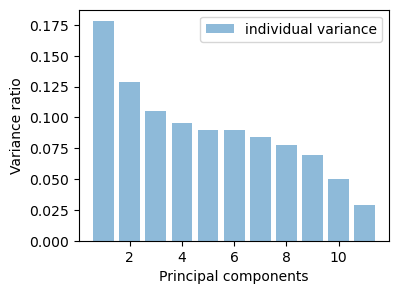

In [12]:
pca_analysis(loan_x_train_transformed, 'loan')

In [13]:
loan_pca_data = PCA(n_components=9, random_state=123).fit_transform(loan_x_train_transformed)
loan_pca_data

array([[-0.30796957, -0.63155151,  0.49135289, ..., -0.12015345,
         0.28081596, -0.11263914],
       [-1.07668319,  0.52397456,  0.08561161, ...,  0.39560707,
        -0.89416219, -0.17613359],
       [ 0.23749102,  0.16999055,  0.30584888, ...,  0.2571482 ,
         0.42800285, -0.5463821 ],
       ...,
       [ 1.57552784, -0.80370623,  0.4446057 , ..., -0.06766375,
         1.41774842, -0.70260655],
       [-0.25537858, -0.85237118, -0.29596096, ...,  0.54153536,
         0.20386383,  2.03348346],
       [-0.5259689 ,  1.08755547,  0.77396689, ...,  0.10356876,
         0.69457629, -0.5976196 ]])

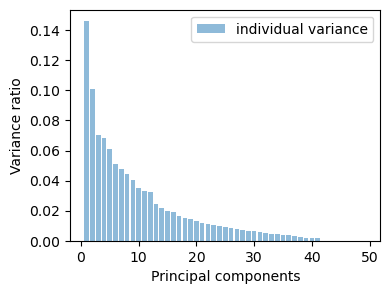

In [14]:
pca_analysis(math_x_train_transformed, 'math')

In [15]:
math_pca_data = PCA(n_components=30, random_state=123).fit_transform(math_x_train_transformed)
math_pca_data

array([[-1.16928941, -1.16015721, -1.29600639, ...,  1.39829582,
         0.2706844 ,  0.29526254],
       [-0.53864226, -1.03132898,  0.64445212, ..., -0.10141193,
        -0.55807137, -0.43673055],
       [-0.02192535, -0.46316863,  1.15704617, ..., -0.89958714,
         1.10183077,  0.61758547],
       ...,
       [-1.34676108, -0.02867123, -1.93730874, ..., -0.15923269,
        -0.04955703, -0.27591425],
       [-4.37030124, -0.00707639,  1.73405554, ...,  0.35993221,
        -0.37231811,  0.06777278],
       [-1.16742295,  1.60850757, -0.96968991, ...,  0.13565473,
         0.18741652, -0.06048099]])

## ICA

In [16]:
from sklearn.decomposition import FastICA

def ica_transform(X_train, n=None):
    if n:
        n = n
    else:
        n = X_train.shape[1]
    ica_model = FastICA(n_components=n, random_state=123)
    ica_model = ica_model.fit(X_train)
    return ica_model.transform(X_train)

In [17]:
loan_ica_data = ica_transform(loan_x_train_transformed, 9)

/opt/miniconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


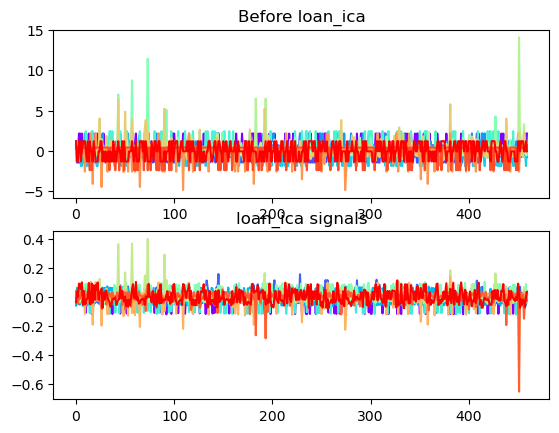

In [18]:
plot_transformed_data(loan_x_train_transformed, loan_ica_data, 'loan_ica')

In [19]:
math_ica_data = ica_transform(math_x_train_transformed, 30)

/opt/miniconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/opt/miniconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


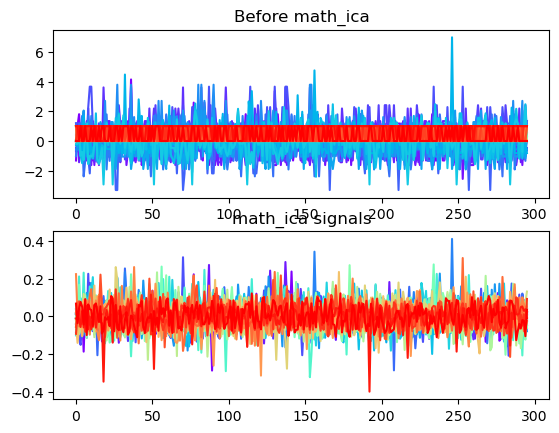

In [20]:
plot_transformed_data(math_x_train_transformed, math_ica_data, 'math_ica')

## Random Projection

In [21]:
from sklearn.random_projection import GaussianRandomProjection

def random_transform(X_train, n=None):
    if n:
        n = n
    else:
        n = X_train.shape[1]
    rp_model = GaussianRandomProjection(n_components=n, random_state=123)
    rp_model = rp_model.fit(X_train)
    return rp_model.transform(X_train)

In [22]:
loan_rt_data = random_transform(loan_x_train_transformed, 9)

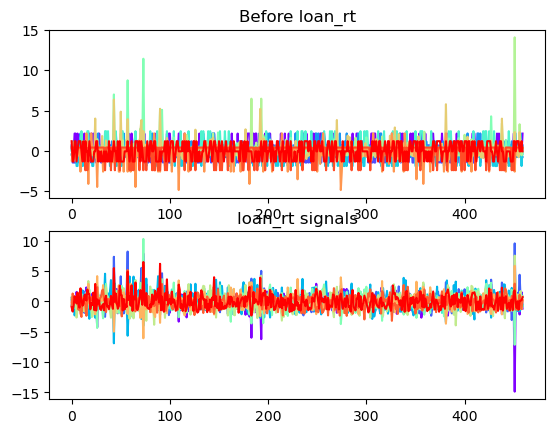

In [23]:
plot_transformed_data(loan_x_train_transformed, loan_rt_data, 'loan_rt')

In [24]:
math_rt_data = random_transform(math_x_train_transformed, 30)

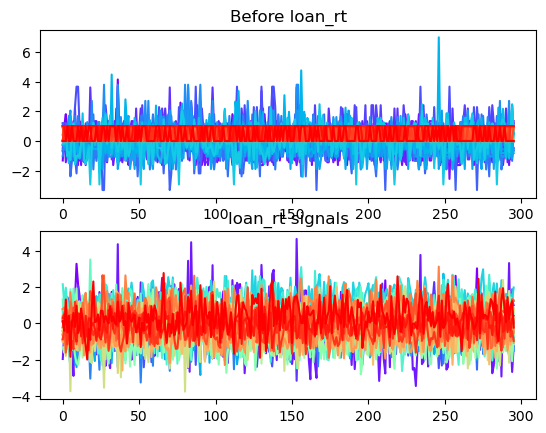

In [25]:
plot_transformed_data(math_x_train_transformed, math_rt_data, 'loan_rt')

## Tree

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

def tree_transform(X_train, y, n=None):
    if n:
        n = n
    else:
        n = X_train.shape[1]
    clf = ExtraTreesClassifier(random_state=123)
    clf = clf.fit(X_train, y)
    tree_model = SelectFromModel(clf, prefit=True, max_features=n)
    transformed_x = tree_model.transform(X_train)
    return transformed_x

In [66]:
loan_tree_data = tree_transform(loan_x_train_transformed, loan_y_train, 9)

In [67]:
math_tree_data = tree_transform(math_x_train_transformed, math_y_train, 30)

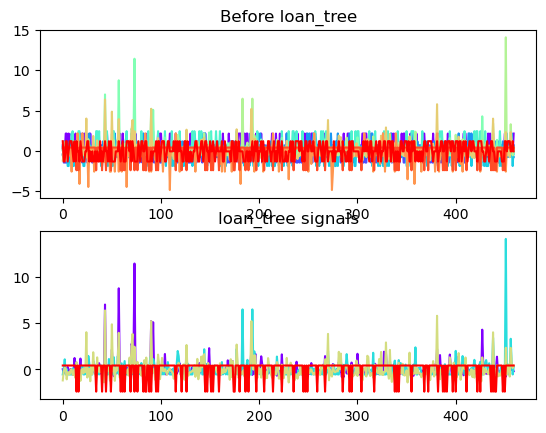

In [29]:
plot_transformed_data(loan_x_train_transformed, loan_tree_data, 'loan_tree')

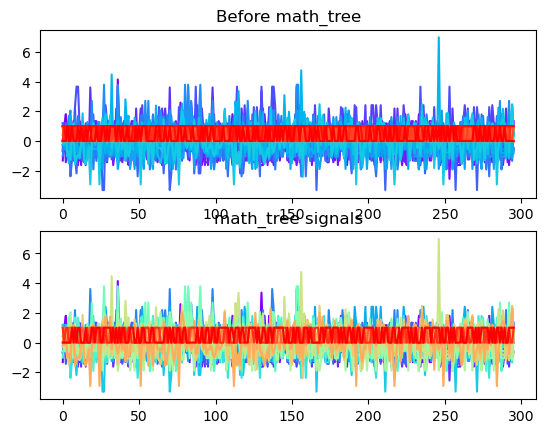

In [30]:
plot_transformed_data(math_x_train_transformed, math_tree_data, 'math_tree')

## PCA + k-means

In [31]:
loan_metric_df = compare_k_values(loan_pca_data, loan_y_train)
plot_kmeans(loan_metric_df, True)

alt.RepeatChart(...)

In [32]:
math_metric_df = compare_k_values(math_pca_data, math_y_train)
plot_kmeans(math_metric_df, True)

alt.RepeatChart(...)

## ICA + k-means

In [33]:
loan_metric_df = compare_k_values(loan_ica_data, loan_y_train)
plot_kmeans(loan_metric_df, True)

alt.RepeatChart(...)

In [34]:
math_metric_df = compare_k_values(math_ica_data, math_y_train)
plot_kmeans(math_metric_df, True)

alt.RepeatChart(...)

## Random + k-means

In [35]:
loan_metric_df = compare_k_values(loan_rt_data, loan_y_train)
plot_kmeans(loan_metric_df, True)

alt.RepeatChart(...)

In [36]:
math_metric_df = compare_k_values(math_rt_data, math_y_train)
plot_kmeans(math_metric_df, True)

alt.RepeatChart(...)

## Tree + k-means

In [37]:
loan_metric_df = compare_k_values(loan_tree_data, loan_y_train)
plot_kmeans(loan_metric_df, True)

alt.RepeatChart(...)

In [38]:
math_metric_df = compare_k_values(math_tree_data, math_y_train)
plot_kmeans(math_metric_df, True)

alt.RepeatChart(...)

In [39]:
def plot_transformed_gm(gm_df):
    
    gm_chart = alt.Chart(gm_df).mark_line(opacity=0.8, point=True).encode(
         alt.X('n'),
         alt.Y(alt.repeat(), type='quantitative', scale=alt.Scale(zero=False))
    ).properties(
        width=200,
        height=200
    ).repeat(
        ['silhouette_score', 'adjusted_rand_score', 'adjusted_mutual_info_score'],
        columns=3
    )
    return gm_chart

## PCA + EM

In [40]:
loan_metric_df = compare_n_values(loan_pca_data, loan_y_train)
plot_transformed_gm(loan_metric_df)

alt.RepeatChart(...)

In [42]:
math_metric_df = compare_n_values(math_pca_data, math_y_train)
plot_transformed_gm(math_metric_df)

alt.RepeatChart(...)

## ICA + EM

In [43]:
loan_metric_df = compare_n_values(loan_ica_data, loan_y_train)
plot_transformed_gm(loan_metric_df)

alt.RepeatChart(...)

In [44]:
math_metric_df = compare_n_values(math_ica_data, math_y_train)
plot_transformed_gm(math_metric_df)

alt.RepeatChart(...)

## Random + EM

In [45]:
loan_metric_df = compare_n_values(loan_rt_data, loan_y_train)
plot_transformed_gm(loan_metric_df)

alt.RepeatChart(...)

In [46]:
math_metric_df = compare_n_values(math_rt_data, math_y_train)
plot_transformed_gm(math_metric_df)

alt.RepeatChart(...)

## Tree + EM

In [49]:
loan_metric_df = compare_n_values(loan_tree_data, loan_y_train)
plot_transformed_gm(loan_metric_df)

alt.RepeatChart(...)

In [48]:
math_metric_df = compare_n_values(math_tree_data, math_y_train)
plot_transformed_gm(math_metric_df)

alt.RepeatChart(...)

## Tree Math + NN

In [71]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


# the following code refers sklearn documentation site and a tutorial on plotting learning curves:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
# https://www.dataquest.io/blog/learning-curves-machine-learning/
class NeuralNetworkAnalysis:
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.nnetwork = MLPClassifier(activation='logistic')
    
    def result_analysis(self):
        self.nnetwork.fit(self.x_train, self.y_train)
        y_train_pred = self.nnetwork.predict(self.x_train)
        y_test_pred = self.nnetwork.predict(self.x_test)
        print(f'Train score {accuracy_score(y_train_pred, self.y_train)}')
        print(f'Test score {accuracy_score(y_test_pred, self.y_test)}')


if __name__ == "__main__":
    # loan_x_train_transformed, loan_tree_data
    loan_pca_test = PCA(n_components=9, random_state=123).fit_transform(loan_x_test_transformed)

    tester1 = NeuralNetworkAnalysis(x_train=loan_pca_data,
                                    x_test=loan_pca_test,
                                    y_train=loan_y_train,
                                    y_test=loan_y_test)
    
    tester1.result_analysis()
    
    loan_tree_data_2 = PCA(n_components=5, random_state=123).fit_transform(loan_x_train_transformed)
    loan_x_tree_test_data_2 = PCA(n_components=5, random_state=123).fit_transform(loan_x_test_transformed)
    tester2 = NeuralNetworkAnalysis(x_train=loan_tree_data_2,
                                    x_test=loan_x_tree_test_data_2,
                                    y_train=loan_y_train,
                                    y_test=loan_y_test)
    
    tester2.result_analysis()
    
    tester3 = NeuralNetworkAnalysis(x_train=loan_x_train,
                                    x_test=loan_x_test,
                                    y_train=loan_y_train,
                                    y_test=loan_y_test)
    tester3.result_analysis()

Train score 0.8021739130434783
Test score 0.7272727272727273
Train score 0.7652173913043478
Test score 0.6558441558441559
Train score 0.6956521739130435
Test score 0.7142857142857143


/opt/miniconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Tree Math + Clustering + NN

In [54]:
loan_x_train_transformed

array([[-0.46575875,  0.69217027,  0.20631248, ...,  0.27778225,
         0.41649656,  1.20186498],
       [-0.46575875, -1.44473123, -0.77207659, ...,  0.27778225,
         0.41649656, -1.31684978],
       [-0.46575875, -1.44473123,  1.18470154, ...,  0.27778225,
         0.41649656, -1.31684978],
       ...,
       [-0.46575875,  0.69217027,  2.1630906 , ...,  0.27778225,
         0.41649656, -0.0574924 ],
       [-0.46575875,  0.69217027, -0.77207659, ...,  0.27778225,
         0.41649656,  1.20186498],
       [ 2.14703426,  0.69217027, -0.77207659, ...,  0.27778225,
         0.41649656, -0.0574924 ]])

In [77]:
loan_pred = KMeans(n_clusters=3, random_state=123, max_iter=100, init='random').fit_predict(loan_pca_data)

new_train = np.zeros((loan_pca_data.shape[0],loan_pca_data.shape[1] + 1))
new_train[:,:-1] = loan_pca_data
new_train[:,-1] = loan_pred

loan_pred_test = KMeans(n_clusters=3, random_state=123, max_iter=100, init='random').fit_predict(loan_pca_test)
new_test = np.zeros((loan_pca_test.shape[0],loan_pca_test.shape[1] + 1))
new_test[:,:-1] = loan_pca_test
new_test[:,-1] = loan_pred_test

In [78]:
tester_new = NeuralNetworkAnalysis(x_train=new_train,
                                   x_test=new_test,
                                   y_train=loan_y_train,
                                   y_test=loan_y_test)
    
tester_new.result_analysis()

Train score 0.8021739130434783
Test score 0.7142857142857143


In [79]:
loan_pred = KMeans(n_clusters=2, random_state=123, max_iter=100, init='random').fit_predict(loan_pca_data)

new_train = np.zeros((loan_pca_data.shape[0],loan_pca_data.shape[1] + 1))
new_train[:,:-1] = loan_pca_data
new_train[:,-1] = loan_pred

loan_pred_test = KMeans(n_clusters=3, random_state=123, max_iter=100, init='random').fit_predict(loan_pca_test)
new_test = np.zeros((loan_pca_test.shape[0],loan_pca_test.shape[1] + 1))
new_test[:,:-1] = loan_pca_test
new_test[:,-1] = loan_pred_test

In [ ]:
tester_new = NeuralNetworkAnalysis(x_train=new_train,
                                   x_test=new_test,
                                   y_train=loan_y_train,
                                   y_test=loan_y_test)
    
tester_new.result_analysis()

Train score 0.8043478260869565
Test score 0.7337662337662337
